In [18]:
import tsa_utils
import deep_cnn
import mini_cnn

from shutil import copytree
import numpy as np
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import matplotlib.animation
import tensorflow as tf
from numpy import genfromtxt
import pandas as pd
import sys
sys.path.append(os.getcwd())

import numpy as np
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import matplotlib.animation
import tensorflow as tf
from numpy import genfromtxt
import pandas as pd
import sys
import math 
import sklearn
from sklearn import metrics

sys.path.append(os.getcwd())
import mini_cnn
import pip
pip.main(['install', '--upgrade', 'dask'])
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler
import pickle
import scipy.misc
import skimage.io
import cv2

Requirement already up-to-date: dask in /home/cody/anaconda3/envs/python3/lib/python3.6/site-packages


In [6]:
DATA_PATH="./images/"
CHECKPOINT_PATH="/output/multi-class8"
MODEL_ID="multi_class"


In [7]:
image_df = pd.read_csv(DATA_PATH + 'stage1_labels.csv')
image_df['zone'] = image_df['Id'].str.split("_", expand=True)[1].str.strip()
image_df['id'] = image_df['Id'].str.split("_", expand=True)[0].str.strip()
# image_df=image_df.groupby("id").sum().reset_index()
image_df = image_df[image_df["zone"]=="Zone14"]
safe_labels = image_df[image_df["Probability"]== 0]["id"].unique()
unsafe_labels = image_df[image_df["Probability"]>0]["id"].unique()

In [8]:
all_labels = image_df.id.unique()

In [9]:
def threshold_image(image_path):
    data = tsa_utils.read_data(DATA_PATH + label + ".aps").reshape(16 * 660, 512, order="A")
    data *= 255/data.max() 
    data = data.astype(np.uint8)
    return cv2.adaptiveThreshold(data,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,5)

In [13]:
# for label in all_labels:
#     thresholded_image = threshold_image(DATA_PATH + label + "")
#     thresholded_file = open(DATA_PATH + "thresholded_images/" + label ,"wb+")
#     thresholded_image.dump(thresholded_file)

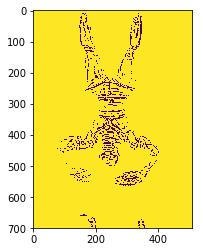

In [30]:
plt.imshow(np.load(DATA_PATH + "/thresholded_images/467cfa7996fcdb7e4f5c4d64c2a01de2").reshape(16 * 660, 512, order="A")[:700,:])
plt.show()

In [19]:
big_safe_pca = sklearn.decomposition.IncrementalPCA(n_components=90)
medium_safe_pca = sklearn.decomposition.IncrementalPCA(n_components=70)
small_safe_pca = sklearn.decomposition.IncrementalPCA(n_components=30)
micro_safe_pca = sklearn.decomposition.IncrementalPCA(n_components=10)
data_buffer = []

for label in safe_labels:
#        data = tsa_utils.read_data(DATA_PATH + label + ".aps").reshape(16 * 660, 512, order="A")
#        data = np.load(DATA_PATH + "/thresholded_images/" + str(label))
    data = threshold_image(DATA_PATH + "/thresholded_images/" + str(label)).flatten()
    data_buffer.append(data)
    if len(data_buffer) > 30:
         big_safe_pca.partial_fit(data_buffer)
         medium_safe_pca.partial_fit(data_buffer)
        small_safe_pca.partial_fit(data_buffer)
        micro_safe_pca.partial_fit(data_buffer)
        data_buffer = []
        print("FINISHED BATCH")
# big_safe_pca.partial_fit(data_buffer)
# medium_safe_pca.partial_fit(data_buffer)
small_safe_pca.partial_fit(data_buffer)
micro_safe_pca.partial_fit(data_buffer)


FINISHED BATCH


MemoryError: 

In [41]:
micro_safe_pca = pickle.load(open("./pca_models/micro_safe_pca.p","rb+"))
small_safe_pca = pickle.load(open("./pca_models/small_safe_pca.p","rb+"))
medium_safe_pca = pickle.load(open("./pca_models/medium_safe_pca.p","rb+"))
large_safe_pca = pickle.load(open("./pca_models/large_safe_pca.p","rb+"))

/home/cody/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.18.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


FileNotFoundError: [Errno 2] No such file or directory: './pca_models/large_safe_pca.p'

In [337]:
unsafe_diffs =[]
for label in unsafe_labels[:5]:
    try:
        print(label)
        data = [threshold_image(DATA_PATH + "/thresholded_images/" + str(label)).flatten()]
        transformed = medium_safe_pca.transform(data)
        reverse_transformed = medium_safe_pca.inverse_transform(transformed) 
        reverse_transformed = reverse_transformed[0]
        data = data[0]
        binary_transformed = reverse_transformed.copy()
        binary_transformed[reverse_transformed > 220] = 0
        binary_transformed[reverse_transformed < 220] = 1
        binary_data = data.copy()
        binary_data[data > 200] = 0
        binary_data[data < 200] = 1
        #diff = data[0] - (reverse_transformed[0] * 1.5)
        #diff = np.minimum(data, reverse_transformed)
        diff = binary_data - binary_transformed
        diff[diff<0] = 0
        diff[diff>0] = 255
        unsafe_diffs.append(diff)
    except Exception as e:
        print(e)

00360f79fd6e02781457eda48f85da90
0043db5e8c819bffc15261b1f1ac5e42
01c08047f617de893bef104fb309203a
087d7648e320f02c2c41e029f6cc2cd0
0ada538288f0b62b01510b397a8acb9e


In [338]:
binary_transformed.sum()

853612.0

In [339]:
def scale_array(array):
    mn = np.min(array)
    mx = np.max(array)
    return np.uint8((array - mn)*255/(mx - mn))

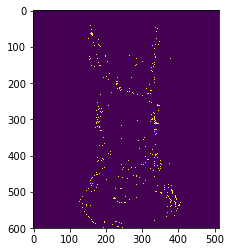

In [340]:
plt.imshow(diff.reshape(-1,512)[5900:6500])
plt.show()

In [341]:

diff

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [342]:
data[0]

255

In [343]:
diff

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [344]:
reverse_transformed[0]

255.00000000004138

In [345]:
skimage.io.imsave("diff2.png", scale_array(diff).reshape(-1,512))
skimage.io.imsave("original2.png", data.reshape(-1,512))
# skimage.io.imsave("unsafe_diff.png", unsafe_diff)
skimage.io.imsave("transformed2.png", scale_array(reverse_transformed.reshape(-1,512)))
skimage.io.imsave("binary_transformed.png", scale_array(binary_transformed.reshape(-1,512)))
skimage.io.imsave("binary_data.png", scale_array(binary_data.reshape(-1,512)))

# skimage.io.imsave("unsafe_transformed.png", unsafe_reverse_transformed)

/home/cody/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: diff2.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [137]:
diff.shape

(10560, 512)

In [ ]:
im.convert("RGB")

In [688]:
np.absolute(unsafe_diff).sum()

71.693889085516389

In [689]:
diff_diff = diff - unsafe_diff

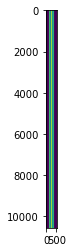

In [50]:
plt.imshow((diff))
plt.show()

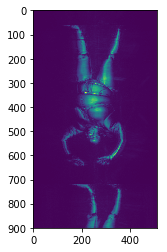

In [547]:
plt.imshow(data[600:1500,:])
plt.show()

In [162]:
image_df = pd.read_csv(DATA_PATH + 'stage1_labels.csv')
image_df['zone'] = image_df['Id'].str.split("_", expand=True)[1].str.strip()
image_df['id'] = image_df['Id'].str.split("_", expand=True)[0].str.strip()
image_df = image_df[(image_df["Probability"]== 1) & (image_df["zone"]== "Zone14")]

labels = image_df["id"].unique()
matrix = []
for label in labels:
    matrix.append(tsa_utils.read_data_coords(DATA_PATH + label + ".aps", "bottom","left")[0].flatten())
unsafe_matrix = np.vstack(matrix)
unsafe_matrix.shape
unsafe_matrix = unsafe_matrix

In [173]:
transformed = safe_pca.transform(unsafe_matrix)
unsafe_reverse_transformed = safe_pca.inverse_transform(transformed)